In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.integrate as integrate
from financepy.models.black import *
from financepy.utils.global_types import *

####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



### Square payoff

In [2]:
def numerical_integration_sq(S0, r, q, T, vol, SD):
    DF = np.exp(-r*T)
    DivF = np.exp(-q*T)
    f = S0*DivF/DF
    maxS = f * np.exp(vol * SD * np.sqrt(T))    
    forward_part = f * f * DF
    model = Black(vol)
    integrand_put = lambda y: 2.0 * model.value(f, y, T, DF, OptionTypes.EUROPEAN_PUT)
    put_part, error = integrate.quad(integrand_put, 0, f)     
    integrand_call = lambda x: 2.0 * model.value(f, x, T, DF, OptionTypes.EUROPEAN_CALL)
    call_part, error = integrate.quad(integrand_call, f, maxS)    
    return forward_part + put_part + call_part

In [3]:
q = 0.05; r = 0.02; T = 1.5; S0 = 10; vol = 0.4
analytical_res = S0*S0*np.exp( r*T -2*q*T + vol*vol*T)
SDs = np.linspace(1, 6, 6)
numIntResults = [numerical_integration_sq(S0, r, q, T, vol, sd) for sd in SDs]
print(analytical_res)
numIntResults

112.74968515793758


[108.15601273732545,
 112.07566800063282,
 112.70281029498767,
 112.74817164300455,
 112.7495752005099,
 112.74959316774772]

In [4]:
q = 0.0; r = 0.0; T = 4; S0 = 1; vol = 0.2
analytical_res = S0*S0*np.exp( r*T -2*q*T + vol*vol*T)
SDs = np.linspace(1, 6, 6)
numIntResults = [numerical_integration_sq(S0, r, q, T, vol, sd) for sd in SDs]
print(analytical_res)
numIntResults

1.1735108709918103


[1.14515450096204,
 1.1698066947673427,
 1.173282990907854,
 1.1735043348512253,
 1.17351035533025,
 1.1735104228706146]

### Variance swap pricing by replicaiton

In [5]:
def numerical_integration_varswap(S0, r, q, T, vol, SD):
    DF = np.exp(-r*T)
    DivF = np.exp(-q*T)
    f = S0*DivF/DF
    maxS = f * np.exp(vol * SD * np.sqrt(T))       
    model = Black(vol)
    integrand_put = lambda y: model.value(f, y, T, DF, OptionTypes.EUROPEAN_PUT) / (y*y)
    put_part, error = integrate.quad(integrand_put, 0.0001, f)     
    integrand_call = lambda x: model.value(f, x, T, DF, OptionTypes.EUROPEAN_CALL) / (x*x)
    call_part, error = integrate.quad(integrand_call, f, maxS)    
    return np.sqrt(2/(T * DF) * (put_part + call_part))

In [6]:
q = 0.05
r = 0.02
T = 1
S0 = 100
vol = 0.20

SDs = np.linspace(1, 6, 6)
numInts = [numerical_integration_varswap(S0, r, q, T, vol, sd) for sd in SDs]

numInts

[0.1933611532022324,
 0.1995434283805737,
 0.19998529917070826,
 0.19999972122454562,
 0.19999991998646785,
 0.19999992220854593]

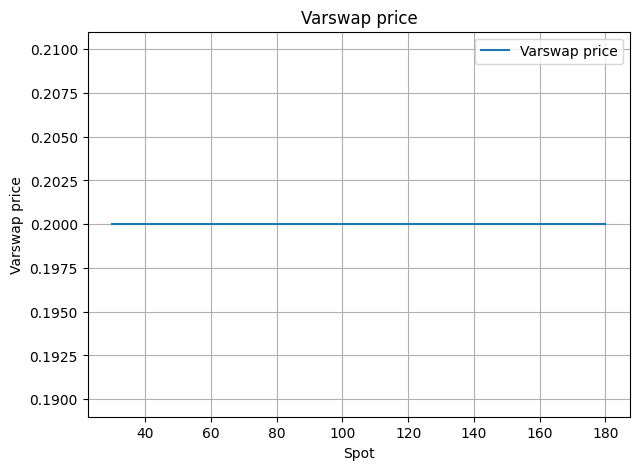

In [7]:
spots = np.linspace(30, 180, 50)
SD = 6
varswap_prices = [numerical_integration_varswap(s0, r, q, T, vol, SD) for s0 in spots]
varswap_prices = [round(p, 8) for p in varswap_prices]

output = np.array([spots, varswap_prices])
output = np.transpose(output)
df = pd.DataFrame(output, columns =['Spot', 'Varswap price']) 
df = df.set_index('Spot')
df.plot(grid=True, figsize=(7, 5))
plt.title("Varswap price")
plt.xlabel("Spot")
plt.ylabel("Varswap price")
#plt.savefig("L6_varswap_price.png")
plt.show()

### Homework 6

In [8]:
def ivol_helper(K):
    return 0.510 - 0.591*K + 0.376*K**2 - 0.105*K**3 + 0.011*K**4

def ivol_HW6(K):
    if K>=3:
        return ivol_helper(3)
    else:
        return ivol_helper(K)
    
def black_with_smile(f, k, t, df, callorput):
    vol = ivol_HW6(k)
    return Black(vol).value(f, k, t, df, callorput)

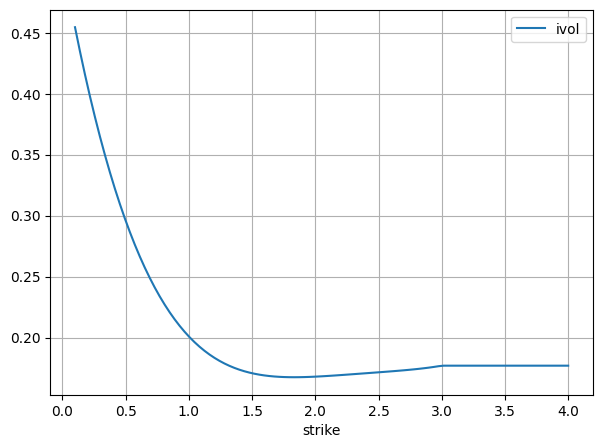

In [9]:
Ks = np.linspace(0.1, 4, 100)
vols = [ivol_HW6(k) for k in Ks]

output = np.array([Ks, vols])
output = np.transpose(output)
df = pd.DataFrame(output, columns =['strike', 'ivol']) 
df = df.set_index('strike')
df.plot(grid=True, figsize=(7, 5))
#plt.savefig("HW6.png")
plt.show()

In [10]:
def numerical_integration_HW6Q1(S0, r, q, T, SD):
    DF = np.exp(-r*T)
    DivF = np.exp(-q*T)
    f = S0*DivF/DF
    vol_for_range = ivol_HW6(f)
    maxS = f * np.exp(vol_for_range * SD * np.sqrt(T))    
    forward_part = np.sqrt(f) * DF
    integrand_put = lambda y: y**(-1.5)/4 * black_with_smile(f, y, T, DF, OptionTypes.EUROPEAN_PUT)
    put_part, error = integrate.quad(integrand_put, 0.0001, f)     
    integrand_call = lambda x: x**(-1.5)/4 * black_with_smile(f, x, T, DF, OptionTypes.EUROPEAN_CALL)
    call_part, error = integrate.quad(integrand_call, f, maxS)    
    return forward_part + put_part + call_part

q = 0.0; r = 0.0; T = 4; S0 = 1
SDs = np.linspace(1, 6, 6)
numIntResults = [numerical_integration_HW6Q1(S0, r, q, T, sd) for sd in SDs]
numIntResults

[1.0255469963305515,
 1.0262077350132235,
 1.0262367979786085,
 1.026237429109531,
 1.0262374320957817,
 1.0262374319912528]

In [11]:
def numerical_integration_HW6Q2(S0, r, q, T, SD):
    DF = np.exp(-r*T)
    DivF = np.exp(-q*T)
    f = S0*DivF/DF
    vol_for_range = ivol_HW6(f)
    maxS = f * np.exp(vol_for_range * SD * np.sqrt(T))    
    forward_part = f * f * f * DF
    integrand_put = lambda y: 6 * y * black_with_smile(f, y, T, DF, OptionTypes.EUROPEAN_PUT)
    put_part, error = integrate.quad(integrand_put, 0, f)     
    integrand_call = lambda x: 6 * x * black_with_smile(f, x, T, DF, OptionTypes.EUROPEAN_CALL)
    call_part, error = integrate.quad(integrand_call, f, maxS)    
    return forward_part + put_part + call_part

q = 0.0; r = 0.0; T = 4; S0 = 1
SDs = np.linspace(1, 6, 6)
numIntResults = [numerical_integration_HW6Q2(S0, r, q, T, sd) for sd in SDs]
numIntResults

[1.4563473089422319,
 1.5157021619075066,
 1.5226666564871445,
 1.5230509011928068,
 1.523056285739455,
 1.523056308079423]

In [12]:
def numerical_integration_sq_with_smile(S0, r, q, T, SD):
    DF = np.exp(-r*T)
    DivF = np.exp(-q*T)
    f = S0*DivF/DF
    vol_for_range = ivol_HW6(f)
    maxS = f * np.exp(vol_for_range * SD * np.sqrt(T))    
    forward_part = f * f * f * DF
    integrand_put = lambda y: 2 * black_with_smile(f, y, T, DF, OptionTypes.EUROPEAN_PUT)
    put_part, error = integrate.quad(integrand_put, 0, f)     
    integrand_call = lambda x: 2 * black_with_smile(f, x, T, DF, OptionTypes.EUROPEAN_CALL)
    call_part, error = integrate.quad(integrand_call, f, maxS)    
    return forward_part + put_part + call_part

q = 0.0; r = 0.0; T = 4; S0 = 1
SDs = np.linspace(1, 6, 6)
numIntResults = [numerical_integration_sq_with_smile(S0, r, q, T, sd) for sd in SDs]
numIntResults

[1.1571881473810026,
 1.1687697382184514,
 1.1696880803112981,
 1.1697230475839275,
 1.1697233784745804,
 1.1697233792321555]